In [80]:
#path = 'saved_model_1001_1' #epoch 60 / 20  large image x3
#path = 'saved_model_1001_softmax_RMSprop_80_30' Not bad, little noisy.
#path = 'saved_model_1001_softmax_RMSprop_100_30_0.0001' #less noisy but stamp not really good
#path = 'saved_models/saved_model_1001_softmax_RMSprop_100_40_0.0005' #less noisy. stamp better.
#path = 'saved_model_1001_softmax_Adam_100_40_0.0005' #little bit worse
#path = 'saved_model_1005_softmax_RMSprop_100_40_0.0005_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_100_30_0.0005_B8_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_50_30_0.0005_B16_with_classweights_100'
#path = 'saved_model_1005_RMSprop_100_0.0005_B1_classweights_P5_S10'
path = 'saved_model_1005_RMSprop_80_0.0005_BNone_classweights_P5_S30'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [31]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Ground Truth Mask', 'Pushed', 'Stamped']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #plt.savefig("EX_1.png")
    plt.axis('off')

  plt.show()

In [18]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

  

In [6]:
mask = imread('images/test/gt_mask/일반7__분리막 눌림_검정.png') #2048 x 2448

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

color_dict = {i: list(x) for i,x in enumerate(colors)}
print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628]}


In [7]:
import glob
import cv2
import gc
gc.collect()

train_x = []
train_y = []

for img in glob.glob("images/train/*/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576)) #960,1152

    flipped = tf.image.flip_left_right(n)

    train_x.append(flipped)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    y = imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576)) #960,1152
    flipped2 = tf.image.flip_left_right(bbb)

    train_y.append(flipped2)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(46, 480, 576, 3)
(46, 480, 576, 1)


In [8]:
sample_image = test_x[0]
sample_mask = test_y[0]

In [54]:
model = tf.keras.models.load_model(path)

In testing Mode...


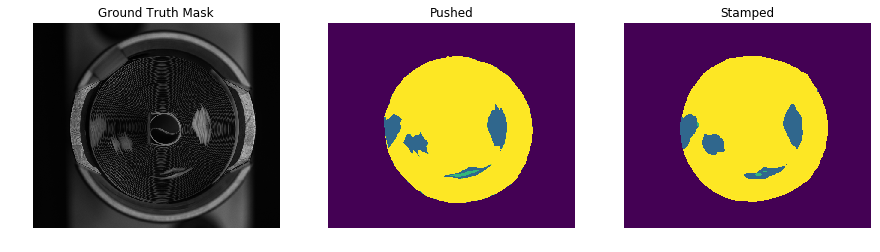

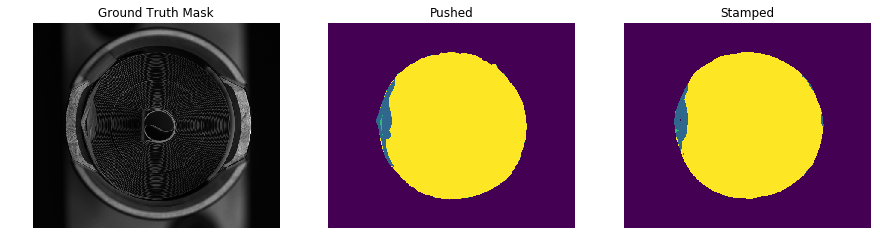

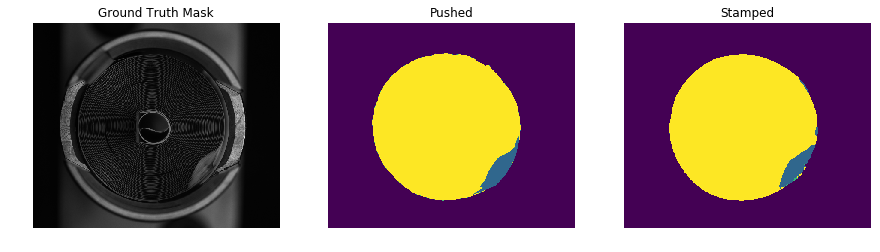

In [55]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=3)

In [56]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tqdm import tqdm
import time

In [57]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [58]:
time_list = []
pred_mask = []

for image in tqdm(test_x):
  start = time.time()
  image = tf.expand_dims(image,0)
  pred_mask.append(frozen_func(image)) # N, H, W, 3
  time_list.append(time.time()-start)

100%|██████████| 46/46 [00:00<00:00, 88.98it/s]


In [59]:
print("Average inference time is: ",np.mean(time_list) * 1000, "ms")
print(time_list)

Average inference time is:  10.927993318308955 ms
[0.2976720333099365, 0.005412578582763672, 0.006470680236816406, 0.0028853416442871094, 0.0042455196380615234, 0.004000425338745117, 0.0030984878540039062, 0.004860401153564453, 0.0030698776245117188, 0.004945516586303711, 0.004067897796630859, 0.003465414047241211, 0.004059791564941406, 0.003442049026489258, 0.004544973373413086, 0.0040476322174072266, 0.004359245300292969, 0.0045168399810791016, 0.004464387893676758, 0.004944801330566406, 0.0038573741912841797, 0.004021644592285156, 0.00423884391784668, 0.0041882991790771484, 0.004594564437866211, 0.004712820053100586, 0.004631996154785156, 0.0046389102935791016, 0.004714012145996094, 0.005548238754272461, 0.004960060119628906, 0.004743337631225586, 0.00469970703125, 0.004235029220581055, 0.004424571990966797, 0.005013465881347656, 0.005240678787231445, 0.005357265472412109, 0.005279541015625, 0.005282878875732422, 0.005081653594970703, 0.0051462650299072266, 0.004985332489013672, 0.0

Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [60]:
!nvidia-smi

Tue Oct  5 07:27:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:81:00.0 Off |                  N/A |
|  0%   32C    P2    75W / 250W |  11773MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [61]:
print(np.shape(pred_mask[0][0][0]))

(480, 576, 4)


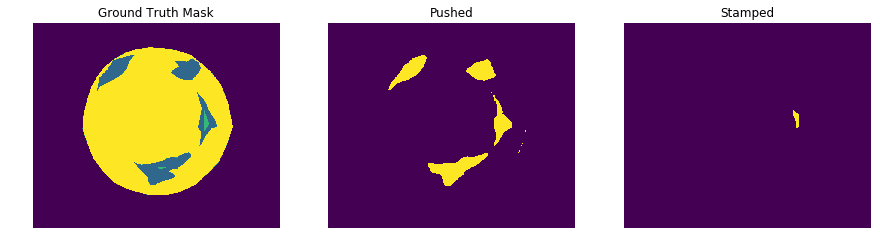

In [75]:
idx = 37
#1 6 (16 22) stamp 3 5 14 push 
ex = pred_mask[idx][0][0]
pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
circle = np.round(tf.expand_dims(ex[:,:,3], -1))
stamped = np.round(tf.expand_dims(ex[:,:,2], -1))

display([test_y[idx],pushed,stamped])
#cv2.imwrite("stamped.png", stamped)

#display([tf.expand_dims(ex[:,:,1], -1), tf.expand_dims(ex[:,:,3], -1), tf.expand_dims(ex[:,:,2], -1)])

Parameter setting for "Stamped"

In [76]:
stamped_x = stamped.astype(np.uint8) * 255

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

#closed_stamp = cv2.morphologyEx(stamped_x, cv2.MORPH_CLOSE, k)

closed_stamp = cv2.dilate(stamped_x, k)

#cv2.imshow("stamp", closed_stamp)

571.0
There are 1 stamp


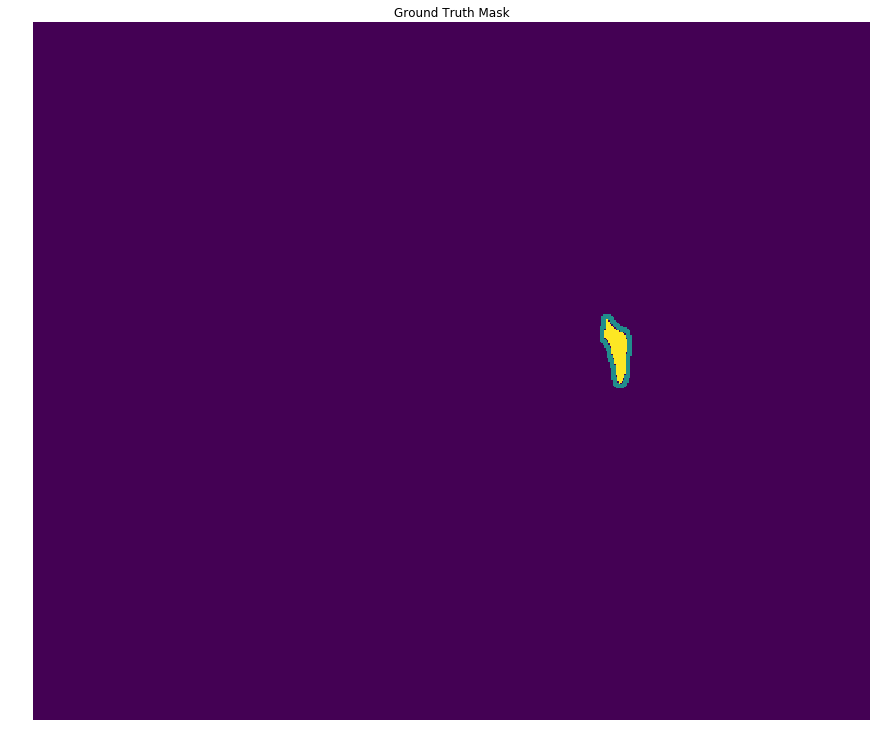

In [77]:
contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
stamp_count = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 100:
        continue
    print(area)
    stamp_count += 1
    
    cv2.drawContours(stamped_x, [cnt], 0, (125, 125, 0), 2)  # blue
    
print("There are {} stamp".format(stamp_count))
display([stamped_x])

In [78]:
pushed_x = pushed.astype(np.uint8) * 255

k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
# 닫힘 연산 적용 ---③
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

#cv2_imshow(closing)

4101.5
2038.5
2165.5
2515.5
There are 4 stamp


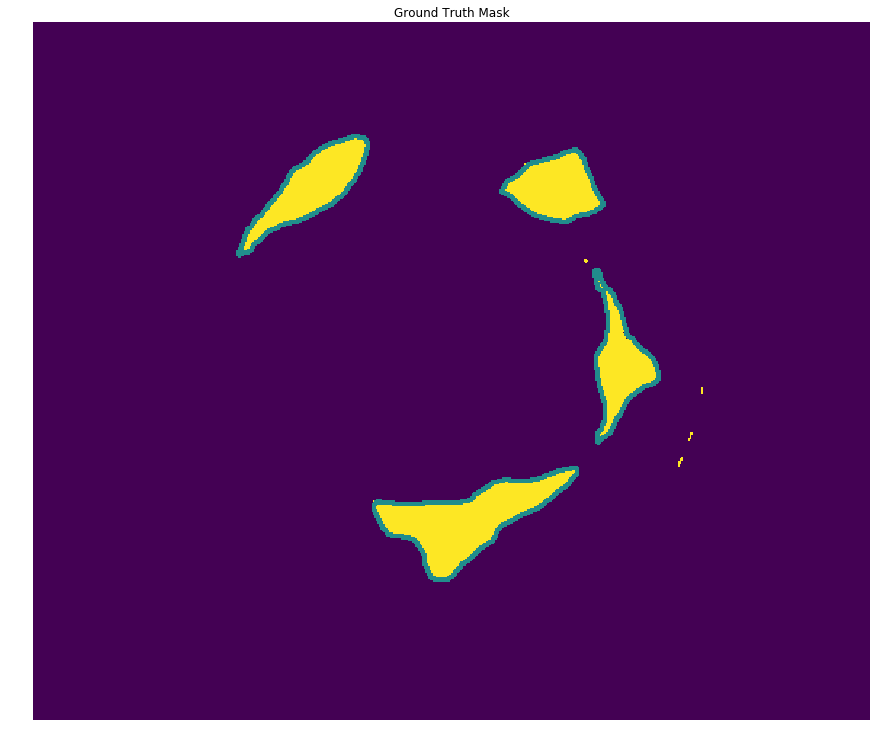

In [79]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

pushed_count = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 250:
        continue
    print(area)
    pushed_count += 1
    
    cv2.drawContours(pushed_x, [cnt], 0, (125, 125, 0), 2)  # blue
    
print("There are {} stamp".format(pushed_count))
display([pushed_x])

In [18]:
import cv2
detector = cv2.SimpleBlobDetector()
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 0
params.maxThreshold = 255

#params.minRepeatability = 2

# Filter by Area.
params.filterByArea = True
params.minArea = 300 #400
params.maxArea = 1e35

# Filter by Color (black=0)
params.filterByColor = True
params.blobColor = 255

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0
params.maxConvexity = 1

# Filter by InertiaRatio
params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

# Distance Between Blobs
params.minDistBetweenBlobs = 70

detector = cv2.SimpleBlobDetector_create(params)

The blob with location 356x99 has size of 25.805822372436523


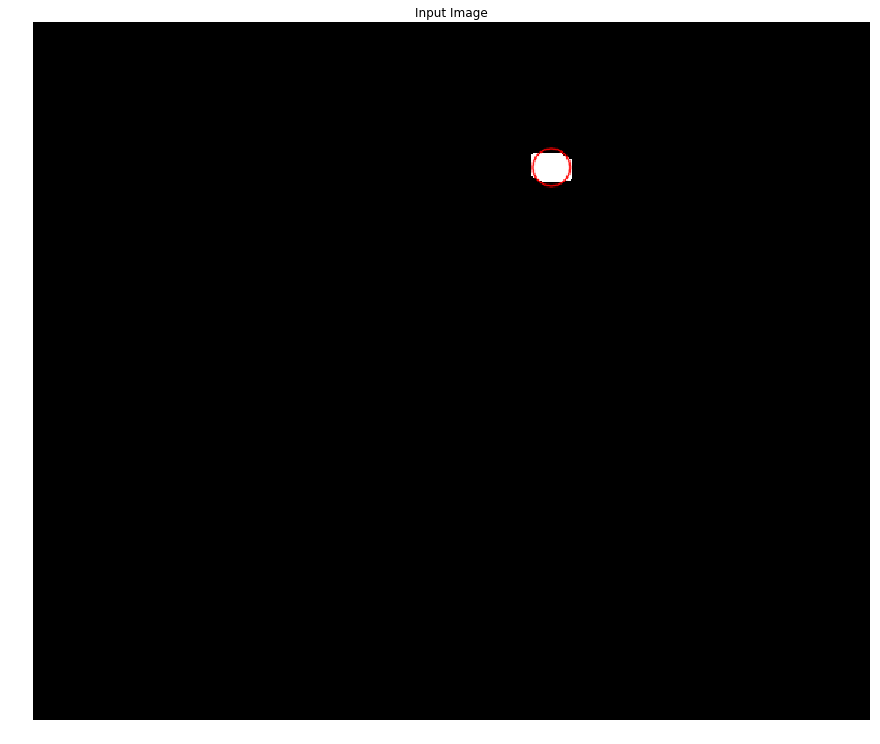

1 stamps detected


In [118]:
import math

keypoints = detector.detect(closed_stamp)
stamp_count = 0

for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print ("The blob with location {}x{} has size of {}".format(x,y,s))
   #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
   stamp_count += 1

# Draw blobs
blobs = cv2.drawKeypoints(closed_stamp, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display([blobs])

print("{} stamps detected".format(stamp_count))

Parameter for "Pushed"

In [119]:
params.minArea = 170 #410
params.minDistBetweenBlobs = 50


params.minInertiaRatio = 0.013
params.maxInertiaRatio = 1 #exclude long ones

detector = cv2.SimpleBlobDetector_create(params)

In [53]:
keypoints = detector.detect(closing)
pushed_count = 0

for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print ("The blob with location {}x{} has size of {}".format(x,y,np.round(s)))
   #cv2.circle(img, (x, y), r, (0, 0, 255), 2)
   pushed_count += 1

# Draw blobs
blobs = cv2.drawKeypoints(closing, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display([blobs])

print("{} pushes detected".format(pushed_count))

NameError: name 'math' is not defined